# Bayesian model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from patsy import dmatrix
import pymc as pm
import arviz as az
az.style.use('arviz-darkgrid')

In [2]:
filepath = '../../../../data/processed/df_filtered_5years_exclude_too_far_islands.xlsx'
df = pd.read_excel(filepath)
df = df[df['island_id'] != 191] # この島は変化率が無限大になるので除外

df['population_change_rate'] = df.groupby('island_id')['population'].pct_change()
df['log_income'] = np.log(df['income'])
df['log_area'] = np.log(df['area_km2'])
df['log_distance'] = np.log(df['distance_m'])
df = df.dropna()

/tmp/ipykernel_25126/4045312990.py:5: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['population_change_rate'] = df.groupby('island_id')['population'].pct_change()


In [3]:
population_change_rate = df['population_change_rate']
bridge = df['dummy_after_bridge_opened']

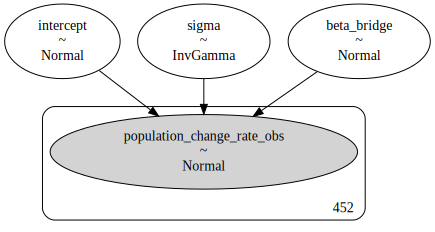

In [4]:
with pm.Model() as model:
    # Priors
    intercept = pm.Normal('intercept', mu=0, sigma=100)
    beta_bridge = pm.Normal('beta_bridge', mu=0, sigma=100)
    sigma = pm.InverseGamma('sigma', alpha=0.001, beta=0.001)

    # linear model
    mu = intercept + beta_bridge * bridge

    # Likelihood
    population_change_rate_obs = pm.Normal('population_change_rate_obs', mu=mu, sigma=sigma, observed=population_change_rate)

# モデルの視覚化
pm.model_to_graphviz(model)

In [5]:
with model:
    idata = pm.sample(
        draws=3000,
        tune=2000,
        nuts_sampler="numpyro",
        return_inferencedata=True,
        init="adapt_diag",
    )

KeyboardInterrupt: 

## アウトプットの保存

In [37]:
az.to_netcdf(idata, 'bm_simple.nc')

'bm_population_change_rate.nc'

## アウトプットのエクスポート

In [15]:
idata = az.from_netcdf('bm_simple.nc')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,-39.835,56.487,-120.711,77.297,25.555,19.274,5.0,20.0,2.09
beta_bridge,0.046,0.016,0.020,0.080,0.005,0.004,11.0,25.0,1.31
gamma[0],28.368,49.072,-41.228,128.683,21.020,16.326,7.0,15.0,1.64
gamma[1],-0.008,0.004,-0.015,-0.001,0.001,0.001,11.0,79.0,1.30
gamma[2],-0.001,0.008,-0.015,0.015,0.002,0.002,14.0,125.0,1.23
delta_year[0],11.461,59.081,-67.099,119.542,27.014,20.405,6.0,24.0,1.77
delta_year[1],0.002,0.123,-0.261,0.237,0.036,0.026,12.0,26.0,1.25
delta_year[2],-0.040,0.081,-0.179,0.134,0.023,0.016,13.0,18.0,1.23
delta_year[3],-0.067,0.067,-0.198,0.074,0.020,0.015,10.0,16.0,1.31
delta_year[4],-0.006,0.068,-0.145,0.135,0.021,0.015,10.0,16.0,1.32


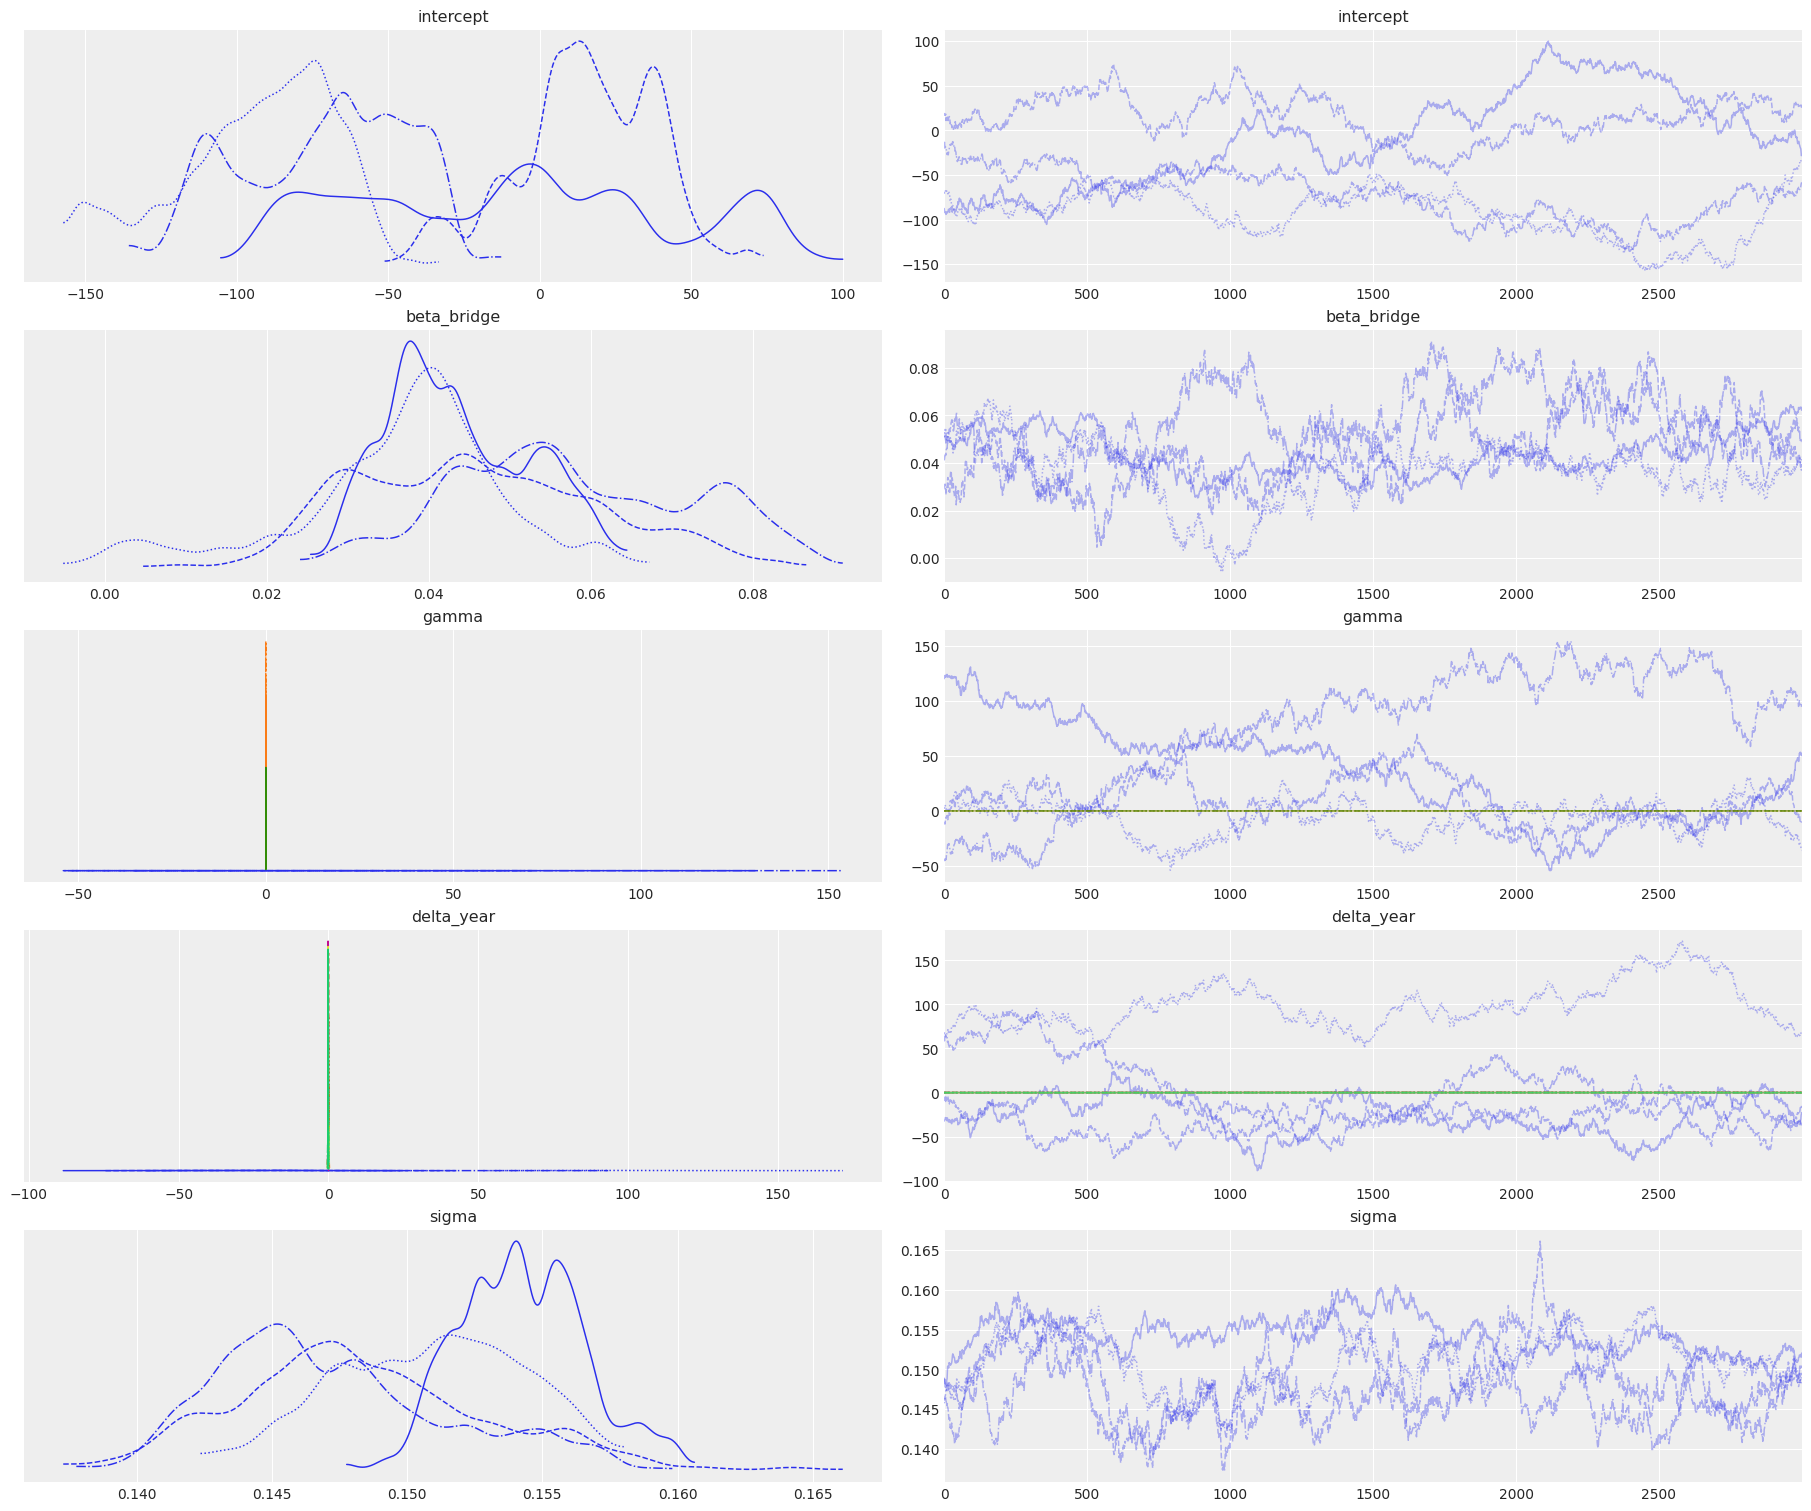

In [18]:
az.plot_trace(idata, figsize=(18, 15))  # サイズを調整
az.summary(idata)

In [40]:
posterior_samples = idata.posterior

beta_bridge_samples = posterior_samples['beta_bridge']

# 0以上のサンプルの割合を計算
prob_intercept_positive = np.mean(posterior_samples['intercept'] > 0)
print(f"Pr(intercept > 0) = {prob_intercept_positive:.4f}")
prob_beta_bridge_positive = np.mean(beta_bridge_samples > 0)
print(f"Pr(beta_bridge > 0) = {prob_beta_bridge_positive:.4f}")
prob_beta_income_positive = np.mean(posterior_samples['beta_income'] > 0)
print(f"Pr(beta_income > 0) = {prob_beta_income_positive:.4f}")
prob_sigma_positive = np.mean(posterior_samples['sigma'] > 0)
print(f"Pr(sigma > 0) = {prob_sigma_positive:.4f}")

Pr(intercept > 0) = 0.0064
Pr(beta_bridge > 0) = 0.9463
Pr(beta_income > 0) = 0.0000
Pr(sigma > 0) = 1.0000
